# Loading the needed libraries

In [1]:
import pandas as pd
import numpy as np

import math
from scipy import stats

import matplotlib.pyplot as plt

import seaborn as sns

from tqdm import tqdm_notebook

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

sns.set_context('talk')
sns.set_style('darkgrid')

from pandas_profiling import ProfileReport

In [62]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import make_scorer, r2_score

from sklearn.svm import SVR

SEED = 42

from sklearn.model_selection import cross_val_score, KFold

from scipy.stats import skew
pd.options.display.float_format = '{:,.2f}'.format

# Loading the data

Исходные данные были добавлены в Excel-таблицу и затем инициализированы как DataFrame с помощью библиотеки pandas. Затем  все значения -200 были заменены на NaN

In [3]:
raw_df = pd.read_excel('AirQualityUCI.xlsx')
raw_df.shape

(9357, 15)

In [4]:
raw_df = raw_df.replace(-200, np.nan)

##### Для справки приведём описание переменных
0. Date	(DD/MM/YYYY) 
1. Time	(HH.MM.SS) 
2. True hourly averaged concentration CO in mg/m^3 (reference analyzer) 
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)	
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
7. True hourly averaged NOx concentration in ppb (reference analyzer) 
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
12. Temperature in Â°C	
13. Relative Humidity (%) 
14. AH Absolute Humidity 

# EDA:
1. Выведем основные статистические показатели
2. Проанализируем пропуски в переменных
3. Выведем вероятностные распределения переменных 
4. Построим и проанализируем корреляционные матрицы

Выведем для ознакомления несколько первых строк датасета

In [5]:
raw_df.head(4).T

,0,1,2,3
Date,2004-03-10 00:00:00,2004-03-10 00:00:00,2004-03-10 00:00:00,2004-03-10 00:00:00
Time,18:00:00,19:00:00,20:00:00,21:00:00
CO(GT),2.60,2.00,2.20,2.20
PT08.S1(CO),"1,360.00","1,292.25","1,402.00","1,375.50"
NMHC(GT),150.00,112.00,88.00,80.00
C6H6(GT),11.88,9.40,9.00,9.23
PT08.S2(NMHC),"1,045.50",954.75,939.25,948.25
NOx(GT),166.00,103.00,131.00,172.00
PT08.S3(NOx),"1,056.25","1,173.75","1,140.00","1,092.00"
NO2(GT),113.00,92.00,114.00,122.00


Описательные статистики датасета

In [6]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),"7,674.00",2.15,1.45,0.10,1.10,1.80,2.90,11.90
PT08.S1(CO),"8,991.00","1,099.71",217.08,647.25,936.75,"1,063.00","1,231.25","2,039.75"
NMHC(GT),914.00,218.81,204.46,7.00,67.00,150.00,297.00,"1,189.00"
C6H6(GT),"8,991.00",10.08,7.45,0.15,4.44,8.24,13.99,63.74
PT08.S2(NMHC),"8,991.00",939.03,266.83,383.25,734.38,909.00,"1,116.25","2,214.00"
NOx(GT),"7,718.00",246.88,212.97,2.00,98.00,179.80,326.00,"1,479.00"
PT08.S3(NOx),"8,991.00",835.37,256.82,322.00,657.88,805.50,969.25,"2,682.75"
NO2(GT),"7,715.00",113.08,48.36,2.00,78.00,109.00,142.00,339.70
PT08.S4(NO2),"8,991.00","1,456.14",346.20,551.00,"1,226.62","1,462.75","1,673.50","2,775.00"
PT08.S5(O3),"8,991.00","1,022.78",398.48,221.00,731.38,963.25,"1,273.38","2,522.75"


Выведем краткую информацию о переменных. 

In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
Date             9357 non-null datetime64[ns]
Time             9357 non-null object
CO(GT)           7674 non-null float64
PT08.S1(CO)      8991 non-null float64
NMHC(GT)         914 non-null float64
C6H6(GT)         8991 non-null float64
PT08.S2(NMHC)    8991 non-null float64
NOx(GT)          7718 non-null float64
PT08.S3(NOx)     8991 non-null float64
NO2(GT)          7715 non-null float64
PT08.S4(NO2)     8991 non-null float64
PT08.S5(O3)      8991 non-null float64
T                8991 non-null float64
RH               8991 non-null float64
AH               8991 non-null float64
dtypes: datetime64[ns](1), float64(13), object(1)
memory usage: 1.1+ MB


# Pandas Profiler

Выведем отчёт о датасете с целью выявить пропуски, проанализировать распределения и корреляции

Не забудем запретить профайлеру отклонять целевую переменную

In [8]:
ProfileReport(raw_df,
              correlation_threshold=0.85,
              correlation_overrides=['C6H6(GT)'])

Number of variables,15
Number of observations,9357
Total Missing (%),4.8%
Total size in memory,1.1 MiB
Average record size in memory,120.0 B
Numeric,8
Categorical,1
Boolean,0
Date,1
Text (Unique),0
Rejected,5


"NMHC(GT) is highly correlated with CO(GT) (ρ = 0.88973)". Переменную NMHC(GT) удаляем чтобы избежать мультиколлинеарности

In [9]:
raw_df = raw_df.drop('NMHC(GT)', 1)

"PT08.S1(CO) is highly correlated with CO(GT) (ρ = 0.87929)". Переменные сильно коррелированы, это может привести к мультиколлинеарности. Удалим первую из них.

In [10]:
raw_df = raw_df.drop('PT08.S1(CO)', 1)

"PT08.S2(NMHC) is highly correlated with C6H6(GT) (ρ = 0.98196)". Переменную PT08.S2(NMHC) не удаляем, так как она коррелирует с целевой переменной.

"PT08.S5(O3) is highly correlated with PT08.S2(NMHC) (ρ = 0.88059) ". Данные переменные тоже сильно коррелированы. Удалим первую из них (оставим переменную, сильно коррелированную с целевой)

In [11]:
raw_df = raw_df.drop('PT08.S5(O3)', 1)

Ещё раз выведем отчёт и проверим изменения. Запретим отклонять также переменную PT08.S2(NMHC), чтобы вывести количество пропусков в ней

In [12]:
ProfileReport(raw_df, correlation_overrides=['C6H6(GT)', 'PT08.S2(NMHC)'])

Number of variables,12
Number of observations,9357
Total Missing (%),6.7%
Total size in memory,877.3 KiB
Average record size in memory,96.0 B
Numeric,10
Categorical,1
Boolean,0
Date,1
Text (Unique),0
Rejected,0


18% (максимальное из всех) пропущенных значений на данном этапе будем считать приемлемым. В дальнейшем эти пропуски будут заполнены или удалены

Выведем матрицу диаграмм рассеяния между наиболее коррелированными с целевой переменной признаками

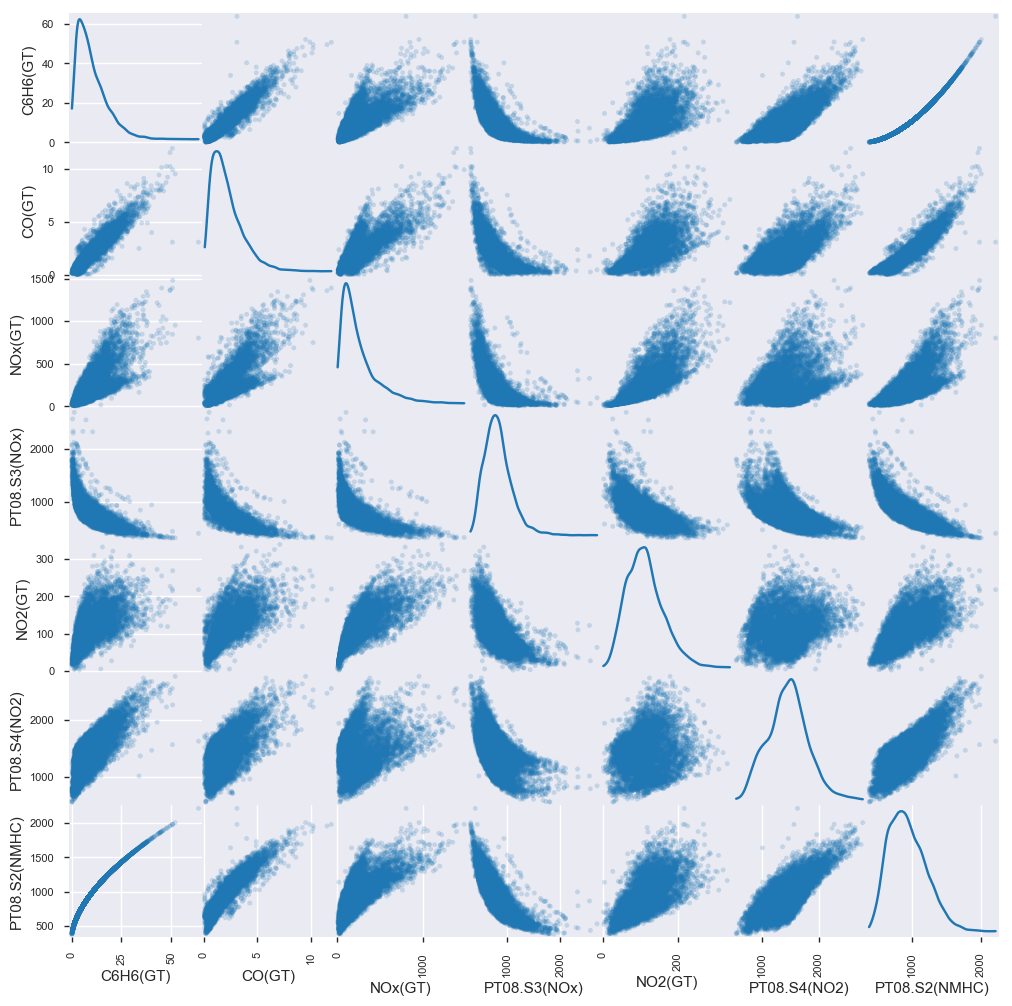

In [13]:
scatter_matrix = pd.DataFrame(data=raw_df,
                              columns=[
                                  'C6H6(GT)', 'CO(GT)', 'NOx(GT)',
                                  'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
                                  'PT08.S2(NMHC)'
                              ])
pd.plotting.scatter_matrix(scatter_matrix,
                           alpha=0.2,
                           figsize=(12, 12),
                           diagonal='kde')
plt.show()

У целевой переменной имеется очень ярко выраженная нелинейная зависимость с признаком PT08.S2(NMHC)

# Заполнение/удаление пропущенных значений

Категориальных переменных две: дата и время. В них пропусков нет.

Выведем информацию о датафрейме с целью определить численные переменные

In [14]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 12 columns):
Date             9357 non-null datetime64[ns]
Time             9357 non-null object
CO(GT)           7674 non-null float64
C6H6(GT)         8991 non-null float64
PT08.S2(NMHC)    8991 non-null float64
NOx(GT)          7718 non-null float64
PT08.S3(NOx)     8991 non-null float64
NO2(GT)          7715 non-null float64
PT08.S4(NO2)     8991 non-null float64
T                8991 non-null float64
RH               8991 non-null float64
AH               8991 non-null float64
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 877.3+ KB


Все численные переменные имеют тип 'float64'. Создадим отдельный датафрейм для численных признаков (в который на этапе обработки пропущенных значений ещё входит целевая переменная) и отдельный для категориальных.

In [15]:
numeric_feats = raw_df.dtypes[raw_df.dtypes == "float64"].index
num_df = raw_df[numeric_feats]

categorical_feats = raw_df.dtypes[raw_df.dtypes != "float64"].index
cat_df = raw_df[categorical_feats]

Посмотрим количество пропущенных значений в численных переменных

In [16]:
num_df.isnull().sum().sort_values(ascending=False)

CO(GT)           1683
NO2(GT)          1642
NOx(GT)          1639
AH                366
RH                366
T                 366
PT08.S4(NO2)      366
PT08.S3(NOx)      366
PT08.S2(NMHC)     366
C6H6(GT)          366
dtype: int64

Для начала попробуем удалить все показания, содержащие пропущенные значения. В дальнейшем при необходимости попробуем заполнить пропуски. После удаления пропусков сделаем контрольную проверку данных

In [17]:
num_df = num_df.dropna()
num_df.isnull().sum().sort_values(ascending=False)

AH               0
RH               0
T                0
PT08.S4(NO2)     0
NO2(GT)          0
PT08.S3(NOx)     0
NOx(GT)          0
PT08.S2(NMHC)    0
C6H6(GT)         0
CO(GT)           0
dtype: int64

Проверим объём оставшихся данных

In [18]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6941 entries, 0 to 9356
Data columns (total 10 columns):
CO(GT)           6941 non-null float64
C6H6(GT)         6941 non-null float64
PT08.S2(NMHC)    6941 non-null float64
NOx(GT)          6941 non-null float64
PT08.S3(NOx)     6941 non-null float64
NO2(GT)          6941 non-null float64
PT08.S4(NO2)     6941 non-null float64
T                6941 non-null float64
RH               6941 non-null float64
AH               6941 non-null float64
dtypes: float64(10)
memory usage: 596.5 KB


Выведем гистограммы. Возможно, распределения надо будет преобразовать

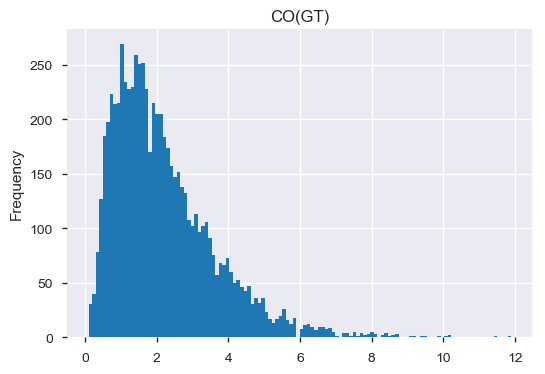

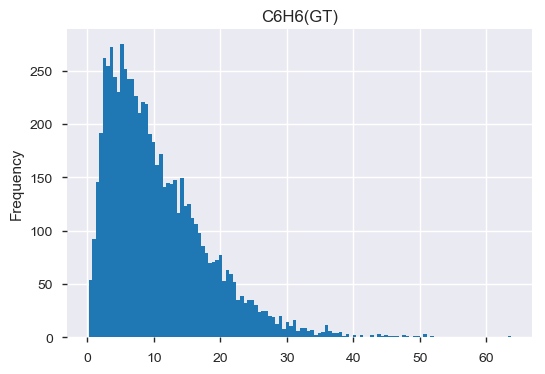

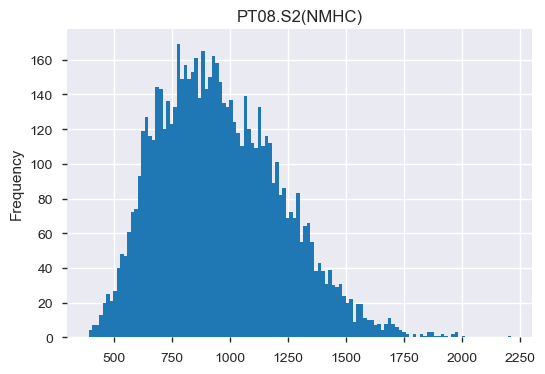

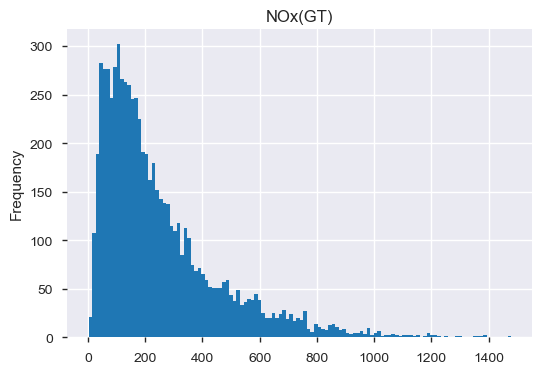

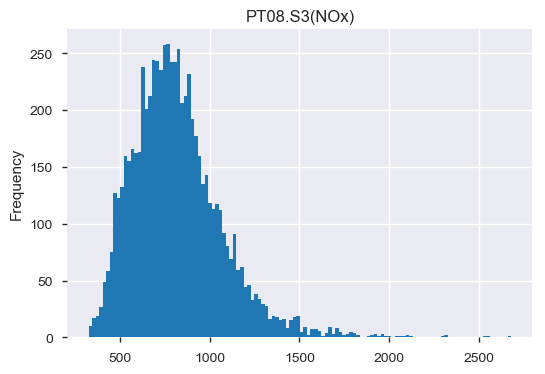

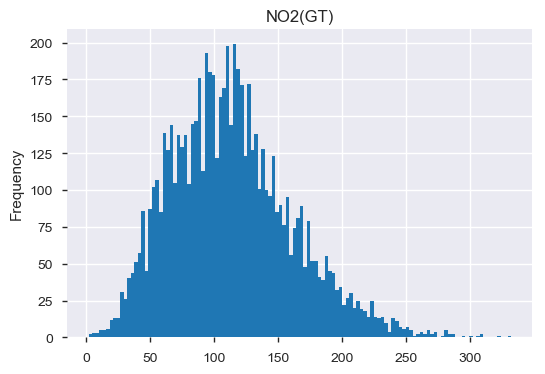

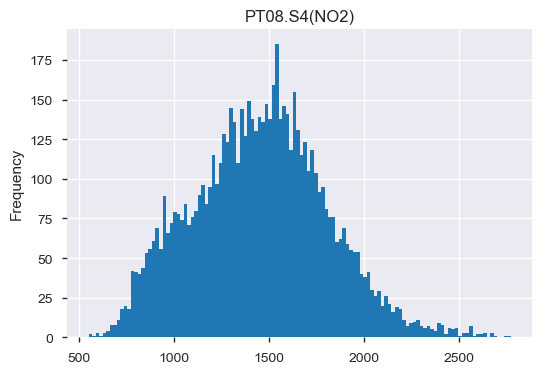

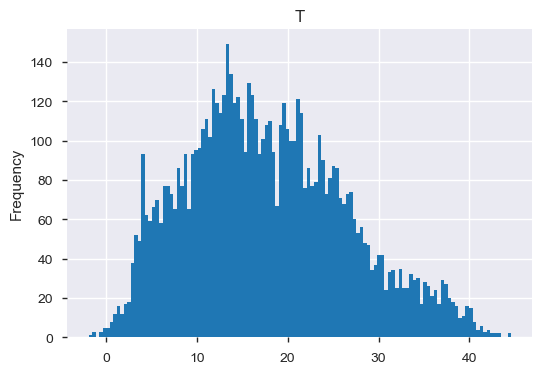

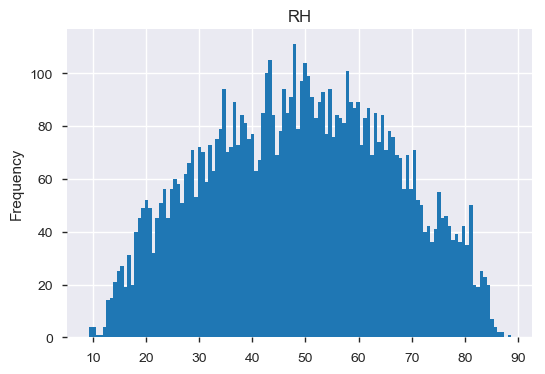

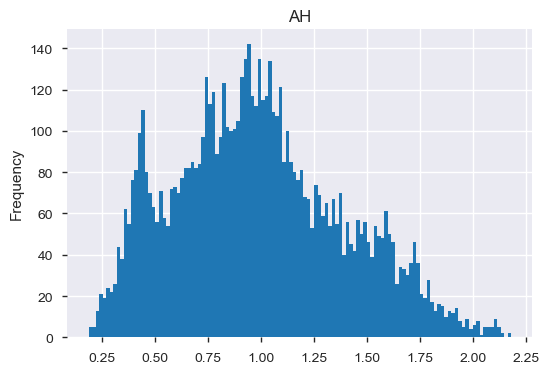

In [19]:
for i in list(num_df.columns)[:]:
    plt.figure()
    plt.title(i)
    num_df[i].plot.hist(bins=120, figsize=(6, 4))
    plt.show()

Невооружённым глазом видно, что некоторые признаки имеют положительную ассиметрию. Вычислим коэффициент ассиметрии и прологарифмируем распределения с коэффициентом выше 0.5

In [20]:
skewed_feats = num_df.apply(lambda x: skew(x))
skewed_feats

CO(GT)           1.34
C6H6(GT)         1.30
PT08.S2(NMHC)    0.51
NOx(GT)          1.64
PT08.S3(NOx)     1.18
NO2(GT)          0.58
PT08.S4(NO2)     0.20
T                0.40
RH              -0.01
AH               0.36
dtype: float64

In [21]:
skewed_feats = skewed_feats[skewed_feats > 0.5]
skewed_feats = skewed_feats.index
num_df[skewed_feats] = np.log1p(num_df[skewed_feats])

Добавим к именам переменных пометку о том, что они логарифмированы. Это может пригодиться при интерпретировании полученных результатов

In [22]:
keys = skewed_feats
values = 'log_' + skewed_feats
new_names = dict(zip(keys, values))

num_df = num_df.rename(columns=new_names)

Снова посмотрим на распределения

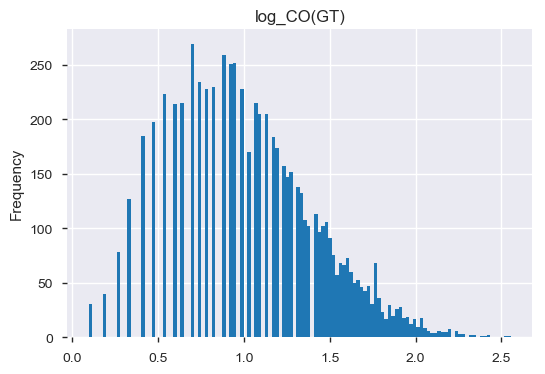

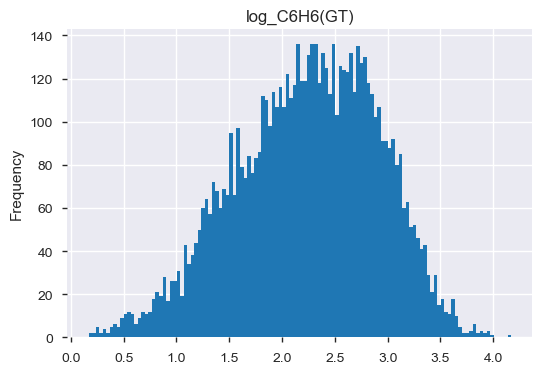

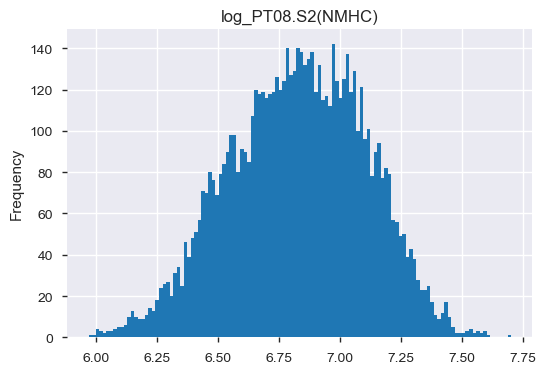

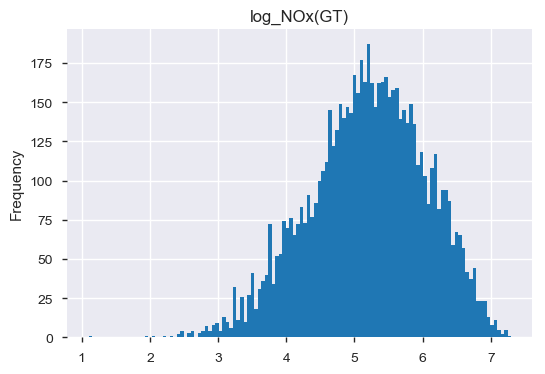

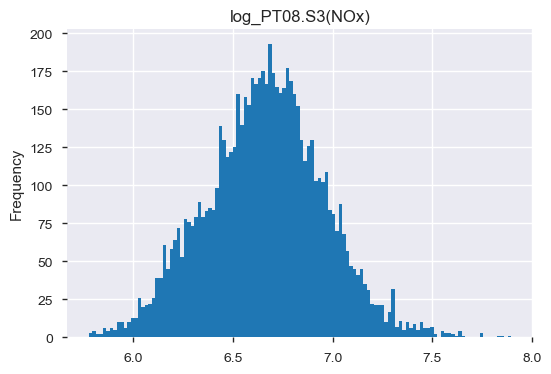

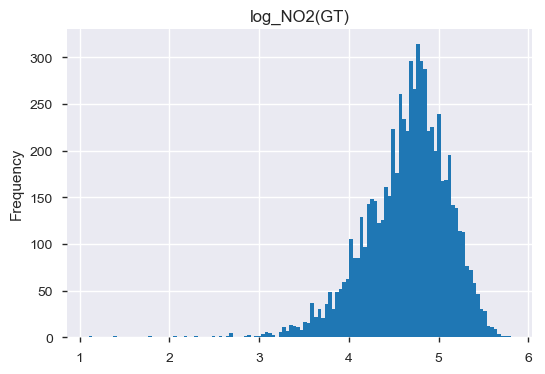

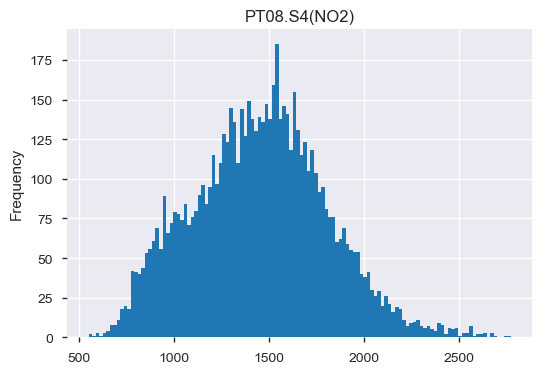

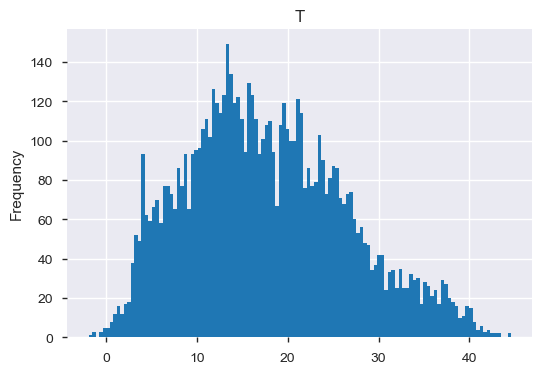

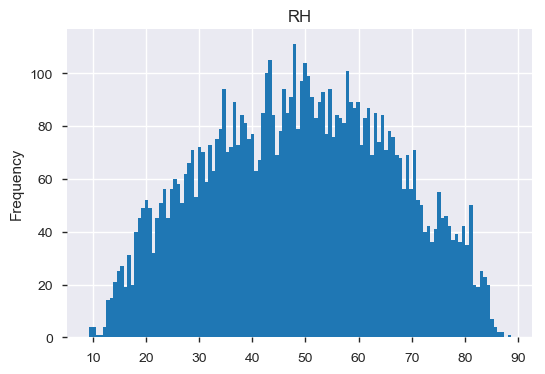

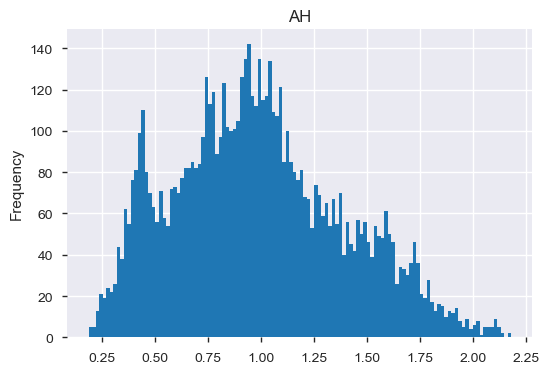

In [23]:
for i in list(num_df.columns)[:]:

    plt.figure()
    plt.title(i)
    num_df[i].plot.hist(bins=120, figsize=(6, 4))
    plt.show()

Распределения стали иметь более "нормальный" вид

# Проверка данных на наличие выбросов

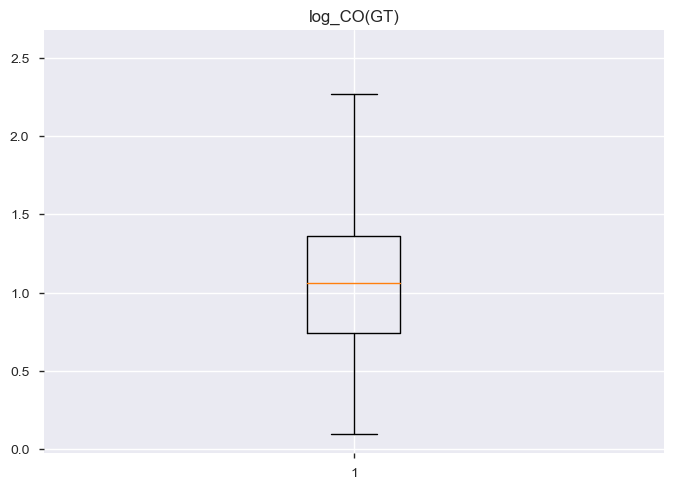

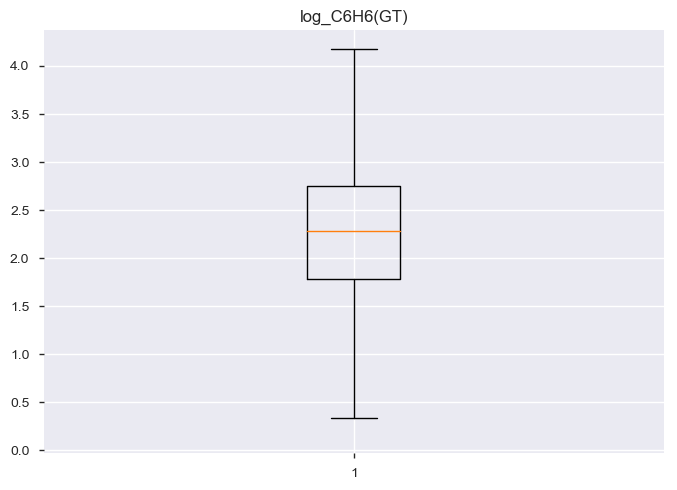

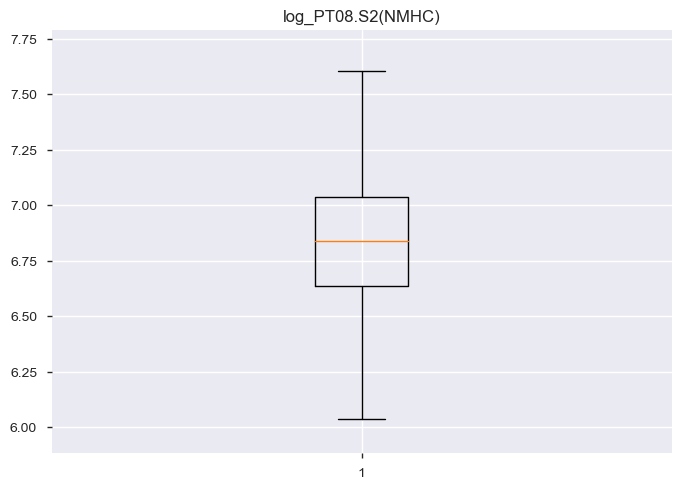

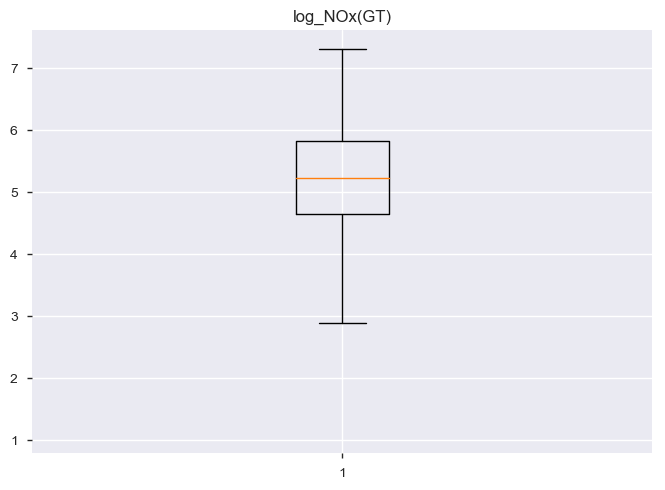

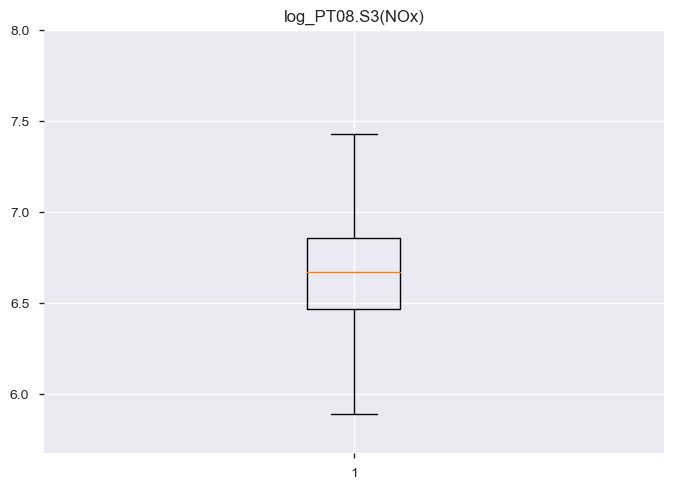

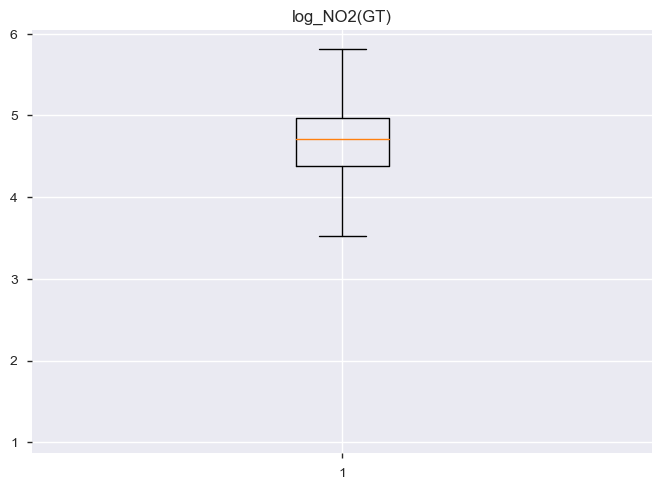

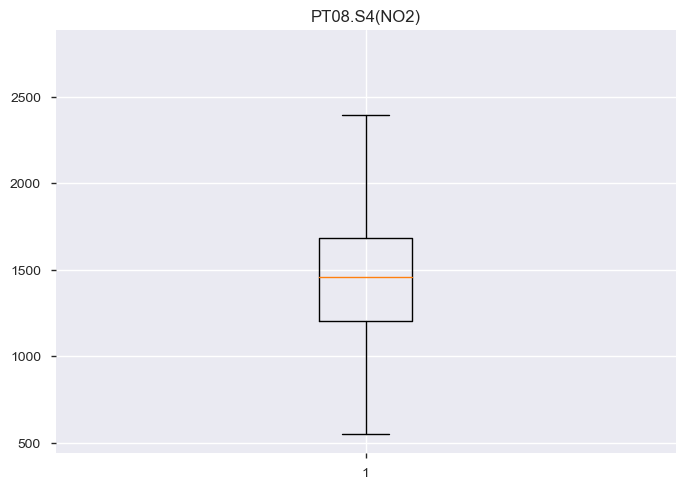

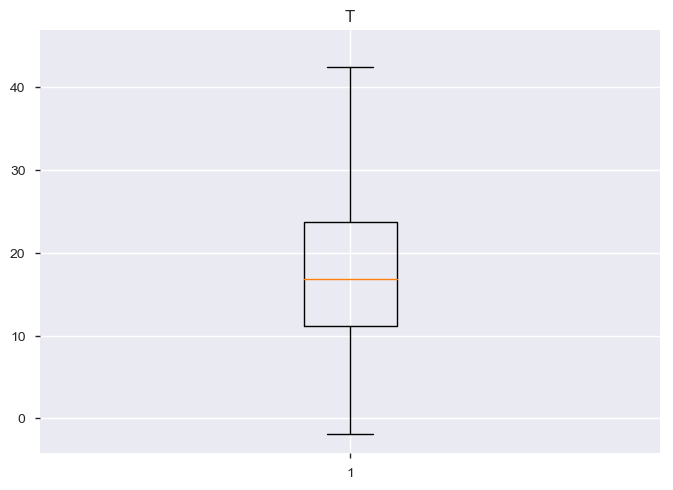

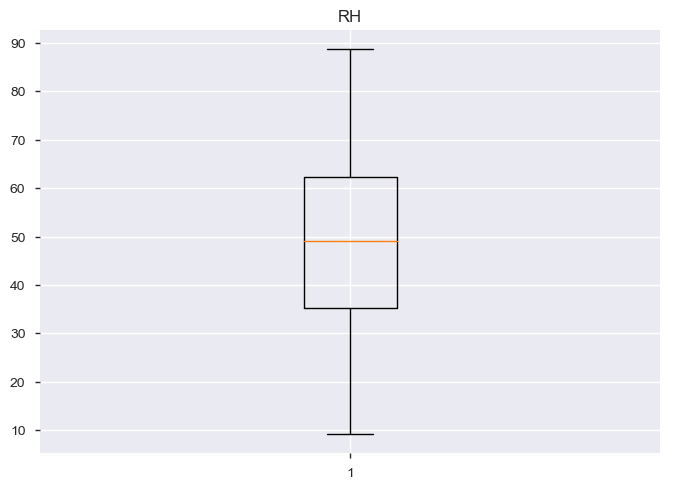

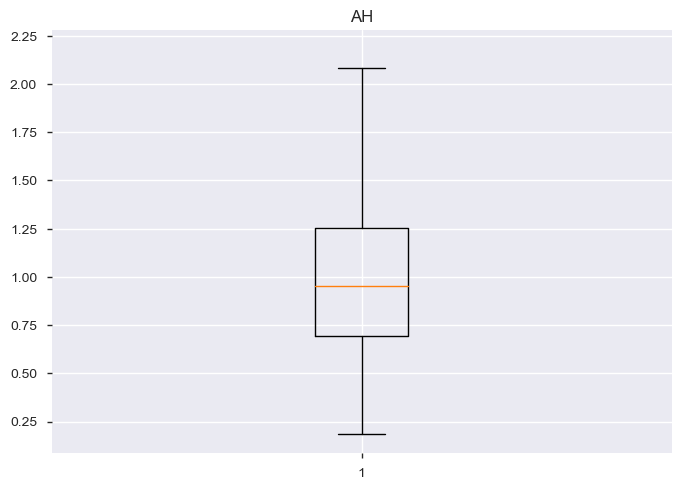

In [24]:
for i in list(num_df.columns)[:]:
    plt.figure()
    plt.title(i)
    plt.boxplot(num_df[i])
    plt.show()

Ни одна переменная не содержит выбросов

# Линейная регрессия без регуляризации. Baseline

Попробуем построить модель линейной регрессии для частично прологарифмированных данных, все пропуски в которых были удалены

На данном этапе представлять категориальные переменные в виде чисел не будем. Попробуем построить линейную регрессию только от численных переменных

In [25]:
all_data = num_df
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6941 entries, 0 to 9356
Data columns (total 10 columns):
log_CO(GT)           6941 non-null float64
log_C6H6(GT)         6941 non-null float64
log_PT08.S2(NMHC)    6941 non-null float64
log_NOx(GT)          6941 non-null float64
log_PT08.S3(NOx)     6941 non-null float64
log_NO2(GT)          6941 non-null float64
PT08.S4(NO2)         6941 non-null float64
T                    6941 non-null float64
RH                   6941 non-null float64
AH                   6941 non-null float64
dtypes: float64(10)
memory usage: 596.5 KB


Выделим целевую переменную и удалим её из признаков

In [26]:
target = all_data['log_C6H6(GT)']
all_data = all_data.drop('log_C6H6(GT)', 1)

Разделим признаки и целевую переменную на тренировочный датасет и тестовый датасет. Обязательно проверим размеры датасетов.

In [27]:
train_feats, test_feats, train_target, test_target = train_test_split(
    all_data, target, test_size=0.3, shuffle=False)

In [28]:
print('train feats shape ', train_feats.shape)
print('train target shape', train_target.shape)
print('test feats shape', test_feats.shape)
print('test target shape', test_target.shape)

train feats shape  (4858, 9)
train target shape (4858,)
test feats shape (2083, 9)
test target shape (2083,)


Создаём модель линейной регрессии и тренируем её на тренировочной выборке

In [29]:
linreg = LinearRegression()
linreg.fit(train_feats, train_target)

Выведем метрику R-квадрат (коэффициент детерминации) по формуле из библиотеки linear_model

In [30]:
linreg.score(test_feats, test_target)

0.9992506291141535

Функция вывода выбранных метрик из библиотеки metrics, а также вычисленных коэффициентов признаков. Метрики выбирались по следующим требованиям: должно быть хотя бы по одной метрике из общих метрик и статистических метрик

In [31]:
def show_metrics_and_coefs(test_target, test_feats, linreg):
    metrics = pd.DataFrame(
        {
            'r2_score': [r2_score(test_target, linreg.predict(test_feats))],
            'mean_squared_error':
            [mean_squared_error(test_target, linreg.predict(test_feats))],
            'median_absolute_error':
            [median_absolute_error(test_target, linreg.predict(test_feats))]
        },
        index=['value'])
    coef_table = pd.DataFrame({
        'feature': test_feats.columns.values.tolist(),
        'coefficient': linreg.coef_.tolist()
    })
    display(metrics.T)
    display(coef_table.T)

In [32]:
show_metrics_and_coefs(test_target, test_feats, linreg)

,value
r2_score,1.00
mean_squared_error,0.00
median_absolute_error,0.01


,0,1,2,3,4,5,6,7,8
feature,log_CO(GT),log_PT08.S2(NMHC),log_NOx(GT),log_PT08.S3(NOx),log_NO2(GT),PT08.S4(NO2),T,RH,AH
coefficient,-0.03,2.61,-0.03,0.04,0.03,-0.00,0.00,0.00,0.03


Коэффициент детерминации равен 1 ( отметим, что значения, вычисленные разными функциями совпадают), значит линейную модель можно считать почти идеальной.  

Коэффициенты у большинства признаков очень маленькие и слабо различаются. Можно выделить признак log_PT08.S2(NMHC), коэффициент которого сильно выделяется на фоне остальных ввиду его сильной кореляции с целевой переменной.

Однако МАО не равно нулю, поэтому модель можно попытаться улучшить.
Попробуем признаки стандартизировать.

# Стандартизация

In [33]:
scaler = StandardScaler()

Стандартизируем признаки

In [34]:
train_feats_scaled = train_feats.copy()
test_feats_scaled = test_feats.copy()

train_feats_scaled[train_feats_scaled.columns] = scaler.fit_transform(
    train_feats_scaled[train_feats_scaled.columns])
test_feats_scaled[test_feats_scaled.columns] = scaler.transform(
    test_feats_scaled[test_feats_scaled.columns])

Создадим модель линейной регрессии для данных, признаки в которых стандартизованы

In [35]:
linreg_scaled = LinearRegression()
linreg_scaled.fit(train_feats_scaled, train_target)

In [36]:
show_metrics_and_coefs(test_target, test_feats_scaled, linreg_scaled)

,value
r2_score,1.00
mean_squared_error,0.00
median_absolute_error,0.01


,0,1,2,3,4,5,6,7,8
feature,log_CO(GT),log_PT08.S2(NMHC),log_NOx(GT),log_PT08.S3(NOx),log_NO2(GT),PT08.S4(NO2),T,RH,AH
coefficient,-0.01,0.71,-0.02,0.01,0.02,-0.04,0.00,0.01,0.01


Ситуация не изменилась по сравнению с первым случаем, когда и признаки, и целевая переменная имели свои масштабы. Получается, стандартизация признаков не дала более точной линейной модели.

# Разработка признаков

Попробуем добавить новых переменных. Для этого вернём исходное состояние переменных после подготовки данных

In [37]:
numeric_feats = raw_df.dtypes[raw_df.dtypes == "float64"].index
num_df = raw_df[numeric_feats]
num_df = num_df.dropna()

skewed_feats = num_df.apply(lambda x: skew(x))
skewed_feats = skewed_feats[skewed_feats > 0.5]
skewed_feats = skewed_feats.index
num_df[skewed_feats] = np.log1p(num_df[skewed_feats])

keys = skewed_feats
values = 'log_' + skewed_feats
new_names = dict(zip(keys, values))

num_df = num_df.rename(columns=new_names)

Выделим целевую переменную, удалим её из признаков проверим объём имеющихся данных

In [38]:
all_data = num_df
target = all_data['log_C6H6(GT)']
all_data = all_data.drop('log_C6H6(GT)', 1)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6941 entries, 0 to 9356
Data columns (total 9 columns):
log_CO(GT)           6941 non-null float64
log_PT08.S2(NMHC)    6941 non-null float64
log_NOx(GT)          6941 non-null float64
log_PT08.S3(NOx)     6941 non-null float64
log_NO2(GT)          6941 non-null float64
PT08.S4(NO2)         6941 non-null float64
T                    6941 non-null float64
RH                   6941 non-null float64
AH                   6941 non-null float64
dtypes: float64(9)
memory usage: 542.3 KB


В параграфе Pandas Profiler было замечено, что целевая переменная имеет ярко выраженную нелинейную зависимость от признака PT08.S2(NMHC), поэтому было решено добавить квадраты и кубы для улучшения регрессионной модели. "Менее важные" переменные не удаляем, пока не убедимся в том, что их вклад действительно не приносит пользы

In [39]:
all_data_pow = all_data.copy()

for feat in all_data.columns:
    square_name = feat + '_square'
    all_data_pow[square_name] = num_df[feat]**2
    cube_name = feat + '_cube'
    all_data_pow[cube_name] = num_df[feat]**3

Проверим добавление новых переменных

In [40]:
all_data_pow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6941 entries, 0 to 9356
Data columns (total 27 columns):
log_CO(GT)                  6941 non-null float64
log_PT08.S2(NMHC)           6941 non-null float64
log_NOx(GT)                 6941 non-null float64
log_PT08.S3(NOx)            6941 non-null float64
log_NO2(GT)                 6941 non-null float64
PT08.S4(NO2)                6941 non-null float64
T                           6941 non-null float64
RH                          6941 non-null float64
AH                          6941 non-null float64
log_CO(GT)_square           6941 non-null float64
log_CO(GT)_cube             6941 non-null float64
log_PT08.S2(NMHC)_square    6941 non-null float64
log_PT08.S2(NMHC)_cube      6941 non-null float64
log_NOx(GT)_square          6941 non-null float64
log_NOx(GT)_cube            6941 non-null float64
log_PT08.S3(NOx)_square     6941 non-null float64
log_PT08.S3(NOx)_cube       6941 non-null float64
log_NO2(GT)_square          6941 non-null f

In [41]:
train_feats, test_feats, train_target, test_target = train_test_split(
    all_data_pow, target, test_size=0.3, shuffle=False)

Чтобы в дальнейшем можно было сравнить коэффициенты признаков, стандартизируем их

In [42]:
train_feats_scaled = train_feats.copy()
test_feats_scaled = test_feats.copy()

train_feats_scaled[train_feats_scaled.columns] = scaler.fit_transform(
    train_feats_scaled[train_feats_scaled.columns])
test_feats_scaled[test_feats_scaled.columns] = scaler.transform(
    test_feats_scaled[test_feats_scaled.columns])

In [43]:
linreg_pow_2_and_3_scaled = LinearRegression()
linreg_pow_2_and_3_scaled.fit(train_feats_scaled, train_target)

In [44]:
show_metrics_and_coefs(test_target, test_feats_scaled,
                       linreg_pow_2_and_3_scaled)

,value
r2_score,1.00
mean_squared_error,0.00
median_absolute_error,0.00


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
feature,log_CO(GT),log_PT08.S2(NMHC),log_NOx(GT),log_PT08.S3(NOx),log_NO2(GT),PT08.S4(NO2),T,RH,AH,log_CO(GT)_square,...,log_NO2(GT)_square,log_NO2(GT)_cube,PT08.S4(NO2)_square,PT08.S4(NO2)_cube,T_square,T_cube,RH_square,RH_cube,AH_square,AH_cube
coefficient,0.02,-4.08,0.01,-0.12,-0.00,0.01,0.00,0.01,-0.00,-0.06,...,0.01,-0.00,-0.04,0.02,-0.00,0.00,-0.02,0.01,0.00,-0.00


Добавление квадрата и куба имеющихся признаков дало идеальные метрики, то есть показало лучшее качество, чем Baseline.

# Отбор признаков

Вглянем на коэффициенты, получившиеся в последней модели

In [45]:
linreg_pow_2_and_3_scaled.coef_

array([ 2.18627791e-02, -4.08191351e+00,  9.77409673e-03, -1.24753103e-01,
       -4.56903259e-03,  1.40193926e-02,  1.39557020e-03,  9.58259428e-03,
       -2.45490957e-03, -5.50274071e-02,  3.27346865e-02,  1.04404352e+01,
       -5.71019589e+00, -1.98628362e-02,  8.62409637e-03,  2.34600554e-01,
       -1.10090175e-01,  9.51664075e-03, -4.92818297e-03, -3.94081595e-02,
        2.38006477e-02, -1.83505720e-03,  1.30666141e-03, -1.64848563e-02,
        8.23495446e-03,  2.98674320e-03, -7.18096233e-04])

В модели присутствует несколько признаков, вклад которых очень мал. Попробуем избавиться от них.

In [46]:
linreg_pow_2_and_3_scaled_coefs = np.asarray(linreg_pow_2_and_3_scaled.coef_)

In [47]:
useless_feats_index = np.where(abs(linreg_pow_2_and_3_scaled_coefs) < 1e-2)

In [48]:
useless_feats_index

(array([ 2,  4,  6,  7,  8, 14, 17, 18, 21, 22, 24, 25, 26], dtype=int64),)

In [49]:
all_data_pow = all_data_pow.drop(all_data_pow.columns[useless_feats_index],
                                 axis=1)

После удалений обязательно проверим работоспособность модели

In [50]:
train_feats, test_feats, train_target, test_target = train_test_split(
    all_data_pow, target, test_size=0.3, shuffle=False)

train_feats_scaled = train_feats.copy()
test_feats_scaled = test_feats.copy()

train_feats_scaled[train_feats_scaled.columns] = scaler.fit_transform(
    train_feats_scaled[train_feats_scaled.columns])
test_feats_scaled[test_feats_scaled.columns] = scaler.transform(
    test_feats_scaled[test_feats_scaled.columns])

linreg_pow_2_and_3_scaled = LinearRegression()
linreg_pow_2_and_3_scaled.fit(train_feats_scaled, train_target)

show_metrics_and_coefs(test_target, test_feats_scaled,
                       linreg_pow_2_and_3_scaled)

,value
r2_score,1.00
mean_squared_error,0.00
median_absolute_error,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
feature,log_CO(GT),log_PT08.S2(NMHC),log_PT08.S3(NOx),PT08.S4(NO2),log_CO(GT)_square,log_CO(GT)_cube,log_PT08.S2(NMHC)_square,log_PT08.S2(NMHC)_cube,log_NOx(GT)_square,log_PT08.S3(NOx)_square,log_PT08.S3(NOx)_cube,PT08.S4(NO2)_square,PT08.S4(NO2)_cube,RH_square
coefficient,0.02,-3.99,-0.07,0.01,-0.06,0.03,10.27,-5.63,-0.00,0.13,-0.06,-0.03,0.02,0.00


Признаков стало меньше, а модель осталась идеальной

# Регуляризация LASSO

Полученная в предыдущем параграфе модель идеальная, но, возможно, получится ещё упростить её и занулить некоторые коэффициенты. Для этого воспользуемся L1-регуляризацией

Для начала посмотрим на коэффициенты нашей итоговой на данный момент модели

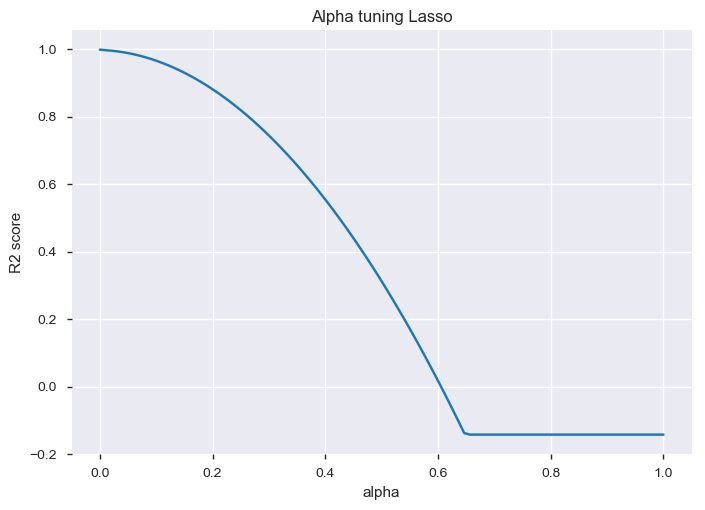

In [51]:
alphas = np.linspace(0, 1, 100)
cv_lasso = [
    Lasso(alpha=alpha).fit(train_feats_scaled,
                           train_target).score(test_feats_scaled, test_target)
    for alpha in alphas
]
cv_lasso = pd.Series(cv_lasso, index=alphas)

cv_lasso.plot(title="Alpha tuning Lasso")
plt.xlabel("alpha")
plt.ylabel("R2 score")

Текущей модели регуляризация LASSO пользы, если судить по метрике R-квадрат, не принесёт. Можно балансировать между точностью и сложностью модели, выбирая alpha на отрезке [0;0.6]. При alpha>0.6 у модели полностью обнуляются коэффициенты и она предсказывает хуже константной.

Попробуем посмотреть на поведение другой метрики

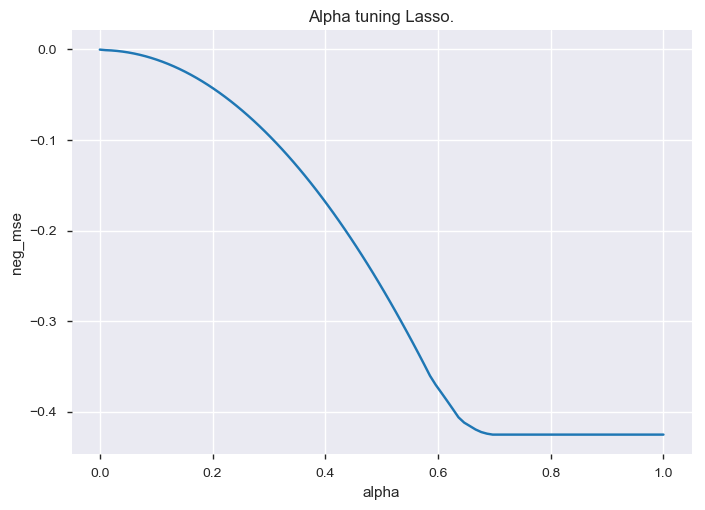

In [52]:
def neg_rmse_cv(model, train_feats_scaled, train_target):
    rmse = cross_val_score(model,
                           train_feats_scaled,
                           train_target,
                           scoring="neg_mean_squared_error",
                           cv=5)
    return (rmse)


cv_lasso = [
    neg_rmse_cv(Lasso(alpha=alpha), train_feats_scaled, train_target).mean()
    for alpha in alphas
]

cv_lasso = pd.Series(cv_lasso, index=alphas)
cv_lasso.plot(title="Alpha tuning Lasso.")
plt.xlabel("alpha")
plt.ylabel("neg_mse")

Ситуация аналогичная. Увеличение alpha только ухудшает точность модели.

Ради эксперимента попробуем применить небольшое alpha. Возможно, модель упростится, а точность всё равно останется приемлемой

In [53]:
linreg_Lasso = Lasso(alpha=0.05)
linreg_Lasso.fit(train_feats_scaled, train_target)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [54]:
show_metrics_and_coefs(test_target, test_feats_scaled, linreg_Lasso)

,value
r2_score,0.99
mean_squared_error,0.01
median_absolute_error,0.04


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
feature,log_CO(GT),log_PT08.S2(NMHC),log_PT08.S3(NOx),PT08.S4(NO2),log_CO(GT)_square,log_CO(GT)_cube,log_PT08.S2(NMHC)_square,log_PT08.S2(NMHC)_cube,log_NOx(GT)_square,log_PT08.S3(NOx)_square,log_PT08.S3(NOx)_cube,PT08.S4(NO2)_square,PT08.S4(NO2)_cube,RH_square
coefficient,0.00,0.60,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00


Сразу видим, что метрики ухудшились. Было протестировано несколько коэффициентов. При больших коэффициентах, как и предполагалось, качество модели сильно падает. Но даже при очень маленьких коэффициентах практически сразу обнуляются коэффициенты перед всеми признаками, кроме PT08.S2(NMHC). Делаем вывод, что можно с большой точностью предсказывать целевую переменную с помощью только одного признака PT08.S2(NMHC)

# Анализ остатков

Проанализируем остатки baseline модели, "идеальной модели со степенями" и модели с регуляцией LASSO

In [55]:
train_feats, test_feats, train_target, test_target = train_test_split(
    all_data, target, test_size=0.3, shuffle=False)
baseline_residuals = test_target - linreg.predict(test_feats)
shapiro = stats.shapiro(baseline_residuals)
print('baseline_residials\nstatistic:{}\np-value:{}\n'.format(
    shapiro[0], shapiro[1]))

ideal_residuals = test_target - linreg_pow_2_and_3_scaled.predict(
    test_feats_scaled)
shapiro = stats.shapiro(ideal_residuals)
print('ideal_residials\nstatistic:{}\np-value:{}\n'.format(
    shapiro[0], shapiro[1]))

lasso_residuals = test_target - linreg_Lasso.predict(test_feats_scaled)
shapiro = stats.shapiro(lasso_residuals)
print('lasso_residials\nstatistic:{}\np-value:{}\n'.format(
    shapiro[0], shapiro[1]))

baseline_residials
statistic:0.9522931575775146
p-value:1.6076232132758767e-25

ideal_residials
statistic:0.6096887588500977
p-value:0.0

lasso_residials
statistic:0.8807695508003235
p-value:2.6448748449843872e-37



Остатки всех рассмотренных моделей распределены нормально при очень маленьком уровне значимости

# Перекрёстная проверка

Попробуем провести кросс-валидацию на "идеальной" модели. Обязательно помним, что мы работаем с данными, содержащими время, и учитываем это при разбиении на фолды

In [56]:
splits = [2, 3, 5, 10, 15, 30, 50, 100, 150, 200]

for i in splits:
    tscv = TimeSeriesSplit(n_splits=i)
    results = cross_val_score(LinearRegression(),
                              train_feats_scaled,
                              train_target,
                              cv=tscv,
                              scoring='r2')
    print(i, "- fold cross-validation r2 score: %.2f" % (results.mean()))

2 - fold cross-validation r2 score: 1.00
3 - fold cross-validation r2 score: 1.00
5 - fold cross-validation r2 score: 1.00
10 - fold cross-validation r2 score: 1.00
15 - fold cross-validation r2 score: 1.00
30 - fold cross-validation r2 score: 1.00
50 - fold cross-validation r2 score: 1.00
100 - fold cross-validation r2 score: 1.00
150 - fold cross-validation r2 score: 1.00
200 - fold cross-validation r2 score: 1.00


Средняя метрика R-квадрат равна метрике модели, которая для обучения использовала тренировочную выборку полностью (0.7 от всех данных). Переобучения не наблюдается. Однако при таких хороших результатах возникает вопрос: а нужно ли использовать так много данных для обучения?

Проверим: будем использовать для обучения только 1 процент данных!

In [57]:
train_feats, test_feats, train_target, test_target = train_test_split(
    all_data_pow, target, test_size=0.99, shuffle=False)

train_feats_scaled = train_feats.copy()
test_feats_scaled = test_feats.copy()

train_feats_scaled[train_feats_scaled.columns] = scaler.fit_transform(
    train_feats_scaled[train_feats_scaled.columns])
test_feats_scaled[test_feats_scaled.columns] = scaler.transform(
    test_feats_scaled[test_feats_scaled.columns])

linreg_pow_2_and_3_scaled = LinearRegression()
linreg_pow_2_and_3_scaled.fit(train_feats_scaled, train_target)

show_metrics_and_coefs(test_target, test_feats_scaled,
                       linreg_pow_2_and_3_scaled)

,value
r2_score,1.00
mean_squared_error,0.00
median_absolute_error,0.01


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
feature,log_CO(GT),log_PT08.S2(NMHC),log_PT08.S3(NOx),PT08.S4(NO2),log_CO(GT)_square,log_CO(GT)_cube,log_PT08.S2(NMHC)_square,log_PT08.S2(NMHC)_cube,log_NOx(GT)_square,log_PT08.S3(NOx)_square,log_PT08.S3(NOx)_cube,PT08.S4(NO2)_square,PT08.S4(NO2)_cube,RH_square
coefficient,0.02,-4.38,-0.89,0.06,-0.04,0.02,11.07,-6.05,0.00,1.69,-0.80,-0.15,0.09,0.00


Ошибка чрезвычайно маленькая, если учитывать объём тренировочной выборки.

Ради интереса выведем первые 5 значений из тестовой выборки и соответствующие предсказания для них

In [58]:
for i in range(5):
    print("test: ", test_target[i:i + 1].values, "pred: ",
          linreg_pow_2_and_3_scaled.predict(test_feats_scaled[i:i + 1]))

test:  [2.6493403] pred:  [2.64954361]
test:  [2.47429784] pred:  [2.47460408]
test:  [2.48185683] pred:  [2.48179086]
test:  [2.5541356] pred:  [2.5552067]
test:  [2.26433051] pred:  [2.2625623]


Всё равно видим поразительно точную модель

Вывод: благодаря наличию одного сильно коррелированного с целевой переменной признака удалось получить очень точную модель, способную обучаться даже на очень маленькой выборке 

# Неклассическая регрессия

Так как результаты "классической" линейной регрессии более, чем устраивают, попробуем просто ради интереса воспользоваться методом опорных векторов

Снова будем использовать 70% датасета для обучения

In [71]:
train_feats, test_feats, train_target, test_target = train_test_split(
    all_data_pow, target, test_size=0.3, shuffle=False)

train_feats_scaled = train_feats.copy()
test_feats_scaled = test_feats.copy()

train_feats_scaled[train_feats_scaled.columns] = scaler.fit_transform(
    train_feats_scaled[train_feats_scaled.columns])
test_feats_scaled[test_feats_scaled.columns] = scaler.transform(
    test_feats_scaled[test_feats_scaled.columns])

Мерилом успеха снова будет метрика R-квадрат

In [72]:
my_scorer = make_scorer(r2_score)

Попробуем 3 ядра и 3 степени для полиномиального ядра. Так как при наличии степеней признаков (были добавлены в параграфе "Разработка признаков") линейная регрессия показала отличные результаты, будем предполагать, что и GridSearch тоже выберет линейное ядро

In [78]:
%%time

tuned_parameters = [{
    'kernel': ['linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4]
}]

svr = GridSearchCV(SVR(),
                   tuned_parameters,
                   scoring=my_scorer,
                   verbose=2,
                   n_jobs=-1)

svr.fit(train_feats_scaled, train_target)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    8.4s finished


Wall time: 8.8 s


In [79]:
svr.best_estimator_

SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Действительно, лучшие результаты показало линейное ядро. Посмотрим на метрику

In [80]:
svr.score(test_feats_scaled, test_target)

0.9943403874610813

Коэффициент детерминации также очень близок, что говорит о том, что модель svr почти идеальная